In [1]:
%reload_ext autoreload
%autoreload

In [2]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
from functools import partial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.visit_attribution as visits
import nomad.filters as filters
import nomad.city_gen as cg

from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [3]:
# create building size categories and dwell classifier function
city = cg.load('../garden-city.pkl')

def classify_dwell(duration): # depends on the diary
    if duration <= 45:
        return 'low'
    elif 45 < duration <= 120:
        return 'mid'
    else:
        return 'high'
        
def size_classifier(n):
    if n == 1:
        return 'small'
    elif 2 <= n <= 3:
        return 'medium'
    else:
        return 'big'

n_blocks = pd.Series({building_id:len(build.blocks) for building_id, build in city.buildings.items()})
building_size = n_blocks.apply(size_classifier)
building_size.name = 'building_size'

In [4]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
poi_table = gpd.read_file('../garden_city.gpkg').join(building_size, on='building_id')
poi_table = poi_table.rename({'type':'building_type'}, axis=1) # annoying

diaries_df = loader.from_file("../../nomad/data/diaries", format="parquet", traj_cols=traj_cols)
diaries_df = diaries_df.rename({'location':'building_id'}, axis=1) # annoying
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_size']], on='building_id')
diaries_df = diaries_df.merge(poi_table[['building_id', 'building_type']], on='building_id')
diaries_df['dwell_length'] = diaries_df['duration'].apply(classify_dwell)

sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,)

## Analyze completeness

In [5]:
completeness_df = filters.q_stats(sparse_df, traj_cols=traj_cols)

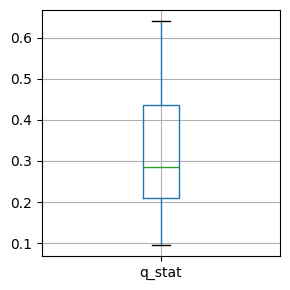

In [6]:
plt.figure(figsize=(3,3))
completeness_df.boxplot(column="q_stat")
plt.grid(True)
plt.tight_layout()

plt.show()

## Execution for all users

In [7]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
summarize_stops_with_loc = partial(utils.summarize_stop, x='x', y='y', keep_col_names=False, passthrough_cols = ['building_id']) # < function(grouped_data)

In [ ]:
stop_detection_algos = ['oracle', 'lachesis', 'ta-dbscan', 'hdbscan']
stop_detection_algos = ['hdbscan', 'oracle']

all_metrics_df = pd.DataFrame()
metrics_size_df = pd.DataFrame()
metrics_btype_df = pd.DataFrame()

TIME_THRESH=240
DIST_THRESH=25
MIN_PTS=2

DT_MAX=240
DELTA_ROAM=35

for user in tqdm(diaries_df.uid.unique()[:10], desc='Processing users'):
    for algo in stop_detection_algos:
        sparse = sparse_df[sparse_df['uid'] == user].copy()
        truth = diaries_df.loc[diaries_df['uid'] == user].copy()
        
        if algo == 'oracle':
            # oracle says correct poi for each ping
            location = visits.oracle_map(
                sparse,
                truth,
                timestamp='timestamp',
                location_id='building_id')
            # find cluster labels with naive grid-based continuity
            labels = GRID_BASED.grid_based_labels(
                data=sparse.join(location),
                time_thresh=TIME_THRESH,
                min_pts=0, #we allow stops of duration 0, patched later
                location_id='building_id',
                traj_cols=traj_cols)
        
        elif algo == 'lachesis':
            labels = LACHESIS._lachesis_labels(
                traj=sparse,
                dt_max=DT_MAX,
                delta_roam=DELTA_ROAM,
                traj_cols=traj_cols)
            
            labels.name = 'cluster'           
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'ta-dbscan':
            labels = TADBSCAN._temporal_dbscan_labels(
                data=sparse,
                time_thresh=TIME_THRESH,
                dist_thresh=DIST_THRESH,
                min_pts=MIN_PTS,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
            
        elif algo == 'hdbscan':
            labels = HDBSCAN.hdbscan_labels(
                traj=sparse,
                time_thresh=TIME_THRESH,
                min_pts=2,
                min_cluster_size=1,
                traj_cols=traj_cols)
            labels.name = 'cluster'
            sparse_with_cluster = sparse.join(labels)
        else:
            print(f"Algorithm {algo} not in the list!")

        # ----------- COMPUTE STOPS FROM LABELS -----------------------
        if algo != 'oracle': 
            pred = visits.point_in_polygon(data=sparse_with_cluster,
                                            poi_table=poi_table,
                                            method='majority',
                                            data_crs='EPSG:3857',
                                            max_distance=15,
                                            cluster_label='cluster',
                                            location_id='building_id',
                                            x='x',
                                            y='y')
        
            pred = sparse_with_cluster.join(pred)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
        # ------------------------------ POST PROCESSING SHOULD BE EMBEDDED IN ALGORITHMS -------------------------------------
            try:
                utils.invalid_stops(stops)
            except:
                labels = GRID_BASED.grid_based_labels(
                                data=pred.drop('cluster', axis=1),
                                time_thresh=TIME_THRESH,
                                min_pts=0, #we allow stops of duration 0, patched later
                                location_id='building_id',
                                traj_cols=traj_cols)
                
                pred['cluster'] = labels
                stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
         # -------------------------------------------------------------------            
        else: #location exists by oracle, we join everything
            pred = sparse.join(location).join(labels)
            stops = pred[pred.cluster!=-1].groupby('cluster', as_index=False).apply(summarize_stops_with_loc, include_groups=False)
            # we add a 5min duration to oracle stops with just one ping
            stops = utils.pad_short_stops(stops, pad=5, dur_min=0, start_timestamp = 'start_timestamp') 

        
        # ------------------------------ COMPUTE METRICS OF INTEREST -------------------------------------
        # general metrics
        overlaps = overlapping_visits(left=stops,
                                      right=truth,
                                      location_id='building_id',
                                      match_location=False)

        errors = compute_visitation_errors(overlaps=overlaps,
                                           true_visits=truth,
                                           location_id='building_id')

        prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                           pred_visits=stops,
                                           true_visits=truth,
                                           location_id='building_id')
        
        all_metrics = {**errors, **prf1, 'user': user, 'algorithm': algo}
        
        
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([all_metrics])], ignore_index=True)

        # WARNING THIS IS WRONG...
        # TO DO: The true way to filter stops, is not with attributes based on PREDICTED location
        # instead, we need clip the stop table to the intervals given by the truth table. >>> PACO
        
        # size metrics
        stops_with_attr = stops.merge(poi_table[['building_id', 'building_size', 'building_type']], on='building_id')
        for build_size in ['small', 'medium', 'big']:    
            if (truth.building_size==build_size).sum() == 0:
                continue
                
            overlaps = overlapping_visits(
                            left=stops_with_attr.loc[stops_with_attr.building_size==build_size],
                            right=truth.loc[truth.building_size==build_size],
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth.loc[truth.building_size==build_size],
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr.loc[stops_with_attr.building_size==build_size],
                                               true_visits=truth.loc[truth.building_size==build_size],
                                               location_id='building_id')
            
            
            metrics_size = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_size':build_size}
            metrics_size_df = pd.concat([metrics_size_df, pd.DataFrame([metrics_size])], ignore_index=True)

        # btype metrics
        for building_type in ['home', 'retail', 'work', 'park']:    
            if (truth.building_type==building_type).sum() == 0:
                continue
                
            overlaps = overlapping_visits(
                            left=stops_with_attr.loc[stops_with_attr.building_type==building_type],
                            right=truth.loc[truth.building_type==building_type],
                            location_id='building_id',
                            match_location=False)
            
            errors = compute_visitation_errors(overlaps=overlaps,
                                               true_visits=truth.loc[truth.building_type==building_type],
                                               location_id='building_id')
            
            prf1 = compute_precision_recall_f1(overlaps=overlaps,
                                               pred_visits=stops_with_attr.loc[stops_with_attr.building_type==building_type],
                                               true_visits=truth.loc[truth.building_type==building_type],
                                               location_id='building_id')
            
            
            metrics_btype = {**errors, **prf1, 'user': user, 'algorithm': algo, 'building_type':building_type}
            metrics_btype_df = pd.concat([metrics_btype_df, pd.DataFrame([metrics_btype])], ignore_index=True)

Processing users:  80%|████████████████████████████████████████████████████             | 8/10 [00:28<00:05,  2.57s/it]

In [ ]:
all_metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

In [ ]:
all_metrics_df.to_csv('metrics_df.csv', index=False)

In [ ]:
# # Postprocessing based on location!
# labels = GRID_BASED.grid_based_labels(
#                 data=pred.drop('cluster', axis=1),
#                 time_thresh=TIME_THRESH,
#                 min_pts=0, #we allow stops of duration 0, patched later
#                 location_id='building_id',
#                 traj_cols=traj_cols)

# pred['cluster'] = labels
# pred = pred.loc[pred.cluster!=-1]

# merged_data_hdbscan = pred.loc[(pred.timestamp>= 1704114480)&(pred.timestamp <= 1704116340)]

In [ ]:
# %matplotlib inline
# # Merging sample data with labels
# fig, ax = plt.subplots(figsize=(6, 6))
# plt.box(on=True)
# # Plotting Garden City Map
# poi_table.plot(ax=ax, color='green', alpha=0.3)
# # Getting colors for clusters
# unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
# cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# if -1 in cluster_mapping:
#     del cluster_mapping[-1]
# mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
# cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# # colors = [‘gray’] + list(cmap_base.colors)
# colors = list(cmap_base.colors)
# extended_cmap = mcolors.ListedColormap(colors)
# # Plotting Pings
# ax.scatter(merged_data_hdbscan['x'],
#            merged_data_hdbscan['y'],
#            c=mapped_clusters,
#            cmap=extended_cmap,
#            s=6,
#            alpha=1,
#            zorder=2)
# ax.set_yticklabels([])
# ax.set_xticklabels([])
# # ax.set_title(“HDBSCAN Stops for Sample User”)
# ax.set_xticks([])
# ax.set_yticks([])
# # ax.set_xlim(12, 22)
# # ax.set_ylim(7, 14)
# plt.tight_layout()
# # plt.savefig(‘gc_empty.png’)
# plt.show()

In [10]:
plot_key = None
plot_value = None
metrics_df = all_metrics_df
#metrics_df = metrics_size_df.loc[metrics_size_df[plot_key]==plot_value]

In [11]:
metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [metrics_df.sample(len(metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_df = pd.concat(output)

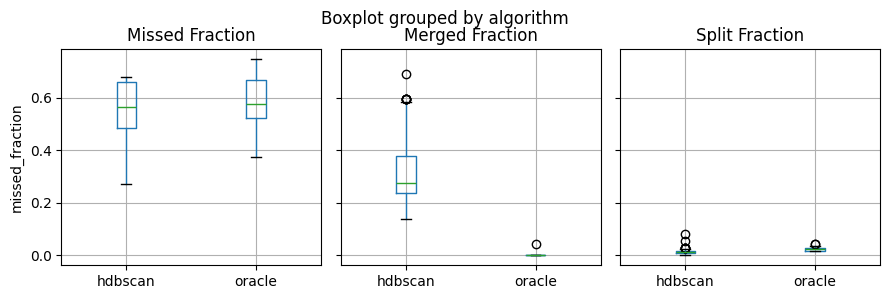

In [12]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.tight_layout()
if plot_key:
    fig.suptitle(f'Fraction of missclassifications for {plot_key} = {plot_value}')
fig.subplots_adjust(top=0.85)
plt.show()

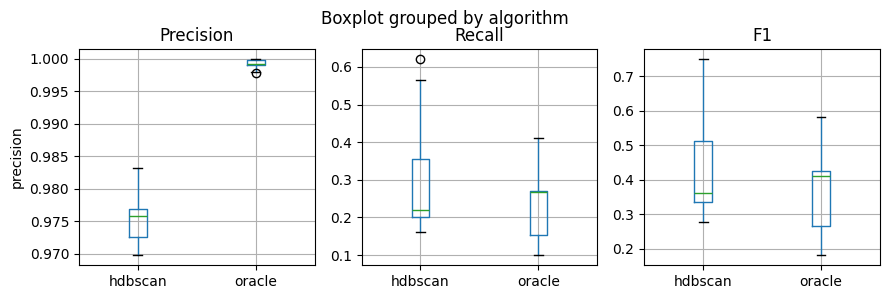

In [13]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, metric in zip(axes, prf_metrics):
    metrics_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.tight_layout()
if plot_key:
    fig.suptitle(f'Error metrics for {plot_key} = {plot_value}')
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
# TO DO: plot to compare algorithm with oracle, x-axis is users sorted by completeness_df.q_stat. y-axis = f1. or recall. 
# Alternatively, q_stat vs F1 scatter plot.

In [ ]:
# TO DO: plot by building area, by dwell time

In [ ]:
# TO DO: expand algorithm list. lachesis_coarse, lachesis_fine, ta_dbscan_coarse, ta_dbscan_fine, oracle_coarse, oracle_fine

## Exploration of building size